In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import re

In [ ]:
# connect to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PATH = '/content/drive/MyDrive/A B Test Team Project/Analysis Code/'

## Data Cleaning

In [ ]:
def normalize_dashes(text):
    """Normalize various dash characters to standard hyphen"""
    return re.sub(r'[–—−]', '-', text) if isinstance(text, str) else text

def parse_income(income_str):
    """Convert income range text to numerical values"""
    income_str = normalize_dashes(income_str).strip() if isinstance(income_str, str) else ''

    if 'Less than $25,000' in income_str:
        return 12500
    elif '$25,000 - $49,999' in income_str:
        return 37500
    elif '$50,000 - $74,999' in income_str:
        return 62500
    elif '$75,000 - $99,999' in income_str:
        return 87500
    elif '$100,000 - $149,999' in income_str:
        return 125000
    elif '$150,000 - $199,999' in income_str:
        return 175000
    elif '$200,000 – $249,999' in income_str:
        return 225000
    elif '$250,000 or more' in income_str:
        return 250000
    else:
        return None

def parse_budget(budget_str):
    """Convert budget range text to numerical values"""
    if budget_str == '$50-$99':
        return 75
    elif budget_str == '$100-$199':
        return 150
    elif budget_str == '$200-$299':
        return 250
    elif budget_str == '$300-$399':
        return 350
    elif budget_str == '$400-$499':
        return 450
    elif budget_str == '$500-$999':
        return 750
    elif budget_str == '$1000+':
        return 1000
    else:
        return None

def parse_star_rating(rating_str):
    """Convert star rating text to numerical values"""
    if rating_str == '1 star (⭐️)':
        return 1
    elif rating_str == '2 stars (⭐️⭐️)':
        return 2
    elif rating_str == '3 stars (⭐️⭐️⭐️)':
        return 3
    elif rating_str == '4 stars (⭐️⭐️⭐️⭐️)':
        return 4
    elif rating_str == '5 stars (⭐️⭐️⭐️⭐️⭐️)':
        return 5
    else:
        return None

def parse_decision_time(time_str):
    """Convert decision time text to hours"""
    if time_str == 'Within an hour':
        return 1
    elif time_str == 'Within a day':
        return 24
    elif time_str == 'Within 3 days':
        return 72
    elif time_str == 'Within a week':
        return 168
    else:
        return 720  # Longer than a week

def get_top_priority(row):
    """Determine top priority factor from rankings"""
    if row['Q7_1'] == '1':  # price
        return 'Price'
    elif row['Q7_2'] == '1':  # location
        return 'Location'
    elif row['Q7_3'] == '1':  # cover photo
        return 'Cover Photo'
    else:
        return 'Ratings/Reviews'  # Q7_4

def clean_airbnb_data(file_path):
    """
    Main function to clean and process the Airbnb survey data

    Parameters:
    file_path (str): Path to the raw CSV data file

    Returns:
    pd.DataFrame: Cleaned and processed dataframe
    """
    # Read raw data
    df0 = pd.read_csv(file_path)

    # Extract data dictionary (from first row)
    data_dictionary = df0.iloc[0].reset_index()

    # Exclude first 2 rows (header information)
    df1 = df0.iloc[2:]

    # Convert duration to integer
    df1['Duration (in seconds)'] = df1['Duration (in seconds)'].astype(int)

    # Convert start date column to datetime and extract day
    df1['StartDay'] = pd.to_datetime(df1['StartDate']).dt.day

    # Filter for completed surveys after April 11
    df2 = df1[(df1['Status'] == 'IP Address') &
              (df1['Progress'] == '100') &
              (df1['StartDay'] >= 12)].iloc[:,[5] + list(range(17, df1.shape[1]))]

    # Create treatment indicator (1 if treated, 0 if control)
    df2['Treatment'] = df2['Q8'].astype(float).apply(lambda x: 1 if np.isnan(x) else 0)

    # Begin conversions from text to numeric
    df3 = df2.copy()

    # Convert income ranges to numeric values
    df3['Q3_total'] = df3['Q3'].apply(parse_income)

    # Fill missing income values with mean
    avg_income = df3[df3['Q3'] != 'Prefer not to say']['Q3_total'].mean()
    df3['Q3_total'] = df3['Q3_total'].fillna(avg_income)

    # Convert budget ranges to numeric values
    df3['Q6_total'] = df3['Q6'].apply(parse_budget)

    # Combine control and treatment responses for click likelihood
    df3['Q8_total'] = df3['Q8'].combine_first(df3['Q8.1']).astype(int)

    # Process perception ratings (price, location, cover photo, ratings)
    # Price perception
    df3['Q9_1_total_text'] = df3['Q9_1'].combine_first(df3['Q9_1.1'])
    df3['Q9_1_total'] = df3['Q9_1_total_text'].apply(parse_star_rating)

    # Location perception
    df3['Q9_2_total_text'] = df3['Q9_2'].combine_first(df3['Q9_2.1'])
    df3['Q9_2_total'] = df3['Q9_2_total_text'].apply(parse_star_rating)

    # Cover photo perception
    df3['Q9_3_total_text'] = df3['Q9_3'].combine_first(df3['Q9_3.1'])
    df3['Q9_3_total'] = df3['Q9_3_total_text'].apply(parse_star_rating)

    # Ratings perception
    df3['Q9_4_total_text'] = df3['Q9_4'].combine_first(df3['Q9_4.1'])
    df3['Q9_4_total'] = df3['Q9_4_total_text'].apply(parse_star_rating)

    # Will save and view later (yes/no)
    df3['Q10_total_text'] = df3['Q10'].combine_first(df3['Q10.1'])
    df3['Q10_total'] = (df3['Q10_total_text'] == 'Yes, I will save it.').astype(int)

    # Decision time
    df3['Q11_total_text'] = df3['Q11'].combine_first(df3['Q11.1'])
    df3['Q11_total'] = df3['Q11_total_text'].apply(parse_decision_time)

    # Determine top priority before seeing listing
    df3['top_priority'] = df3.apply(get_top_priority, axis=1)

    # Process priority rankings after seeing listing
    df3['Q12_1_total'] = df3['Q12_1'].combine_first(df3['Q12_1.1'])
    df3['Q12_2_total'] = df3['Q12_2'].combine_first(df3['Q12_2.1'])
    df3['Q12_3_total'] = df3['Q12_3'].combine_first(df3['Q12_3.1'])
    df3['Q12_4_total'] = df3['Q12_4'].combine_first(df3['Q12_4.1'])

    # Calculate priority ranking changes
    df3['diff_price_rank'] = df3['Q12_1_total'].astype(int) - df3['Q7_1'].astype(int)
    df3['diff_location_rank'] = df3['Q12_2_total'].astype(int) - df3['Q7_2'].astype(int)
    df3['diff_photo_rank'] = df3['Q12_3_total'].astype(int) - df3['Q7_3'].astype(int)
    df3['diff_rating_rank'] = df3['Q12_4_total'].astype(int) - df3['Q7_4'].astype(int)

    # Remove no longer needed columns
    if 'Duration (in seconds)' in df3.columns:
        df3.drop(columns=['Duration (in seconds)'], inplace=True)

    return df3

In [ ]:
# raw_data_path = PATH+'airbnb_survey_responses.csv'
# cleaned_df = clean_airbnb_data(raw_data_path)
# cleaned_df.to_csv("cleaned_airbnb_data.csv", index=False)

## Data Analysis

### demographic metrics
- age
- gender
- income
- nighly budget
- vacation/year
- #people/trip

In [ ]:
def load_and_combine_data(human_file_path, synthetic_file_path):
    """
    Load cleaned human data and optionally combine with synthetic data

    Parameters:
    human_path (str): Path to the cleaned human response CSV
    synthetic_path (str, optional): Path to synthetic data CSV if available

    Returns:
    pd.DataFrame: Combined dataframe
    """
    human_df = pd.read_csv(human_file_path)

    if synthetic_file_path:
        synthetic_df = pd.read_csv(synthetic_file_path)
        combined_df = pd.concat([human_df, synthetic_df])
        combined_df.reset_index(drop=True, inplace=True)
        return combined_df

    return human_df

def analyze_demographics(df):
    """
    Generate and display demographic visualizations

    Parameters:
    df (pd.DataFrame): Cleaned data frame
    """
    plt.figure(figsize=(15, 10))

    # Age distribution
    plt.subplot(2, 2, 1)
    age_counts = df['Q1'].value_counts()
    plt.pie(age_counts, labels=age_counts.index, autopct='%1.1f%%')
    plt.title('Age Distribution')

    # Gender distribution
    plt.subplot(2, 2, 2)
    gender_counts = df['Q2'].value_counts()
    plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%')
    plt.title('Gender Distribution')

    # Nightly budget distribution
    plt.subplot(2, 2, 3)
    budget_counts = df['Q6'].value_counts()
    plt.pie(budget_counts, labels=budget_counts.index, autopct='%1.1f%%')
    plt.title('Nightly Budget Distribution')

    # Most important factor overall
    plt.subplot(2, 2, 4)
    top_priority_counts = df['top_priority'].value_counts()
    plt.pie(top_priority_counts, labels=top_priority_counts.index, autopct='%1.1f%%')
    plt.title('Most Important Factor Overall')

    plt.tight_layout()
    plt.savefig('demographic_analysis.png')
    plt.show()

def analyze_priorities_by_segment(df):
    """
    Analyze how priorities differ by demographic segments

    Parameters:
    df (pd.DataFrame): Cleaned data frame
    """
    # Most important factor by gender
    df_gender = df[['Q2','top_priority']].pivot_table(
        columns='top_priority',
        index='Q2',
        aggfunc='size'
    ).fillna(0)

    plt.figure(figsize=(10, 6))
    ax = df_gender.plot(kind='bar', stacked=False)
    plt.xticks(rotation=0)
    plt.xlabel('Gender')
    plt.ylabel('Count')
    for container in ax.containers:
        ax.bar_label(container, label_type='edge', padding=2)
    ax.legend(title='Priority Factor', loc='upper right', bbox_to_anchor=(1.01, 1), fontsize='small')
    plt.title('Most Important Factor By Gender')
    plt.savefig('priorities_by_gender.png')
    plt.show()

    # Most important factor by nightly budget
    df_budget = df[['Q6','top_priority']].pivot_table(
        columns='top_priority',
        index='Q6',
        aggfunc='size'
    ).fillna(0)

    # Define the desired order of budget ranges
    desired_order = ['$50-$99', '$100-$199', '$200-$299', '$300-$399',
                     '$400-$499', '$500-$999', '$1000+']

    # Sort the index according to desired order
    df_budget_sorted = df_budget.reindex(desired_order).fillna(0)

    plt.figure(figsize=(12, 6))
    ax2 = df_budget_sorted.plot(kind='bar', stacked=False)
    plt.xticks(fontsize=8, rotation=0)
    plt.xlabel('Nightly Budget')
    plt.ylabel('Count')
    for container in ax2.containers:
        ax2.bar_label(container, label_type='edge', padding=2)
    ax2.legend(title='Priority Factor', loc='upper right', bbox_to_anchor=(1.01, 1), fontsize='small')
    plt.title('Most Important Factor By Nightly Budget')
    plt.savefig('priorities_by_budget.png')
    plt.show()

def run_statistical_tests(df):
    """
    Run regression analyses to test hypotheses

    Parameters:
    df (pd.DataFrame): Cleaned data frame

    Returns:
    dict: Dictionary of regression results
    """
    results = {}

    # Income vs. nightly budget relationship
    results['income_budget'] = smf.ols(formula='Q6_total ~ Q3_total', data=df).fit()

    # Treatment effect on click likelihood
    results['treatment_click'] = smf.ols(formula='Q8_total ~ Treatment * Q6_total', data=df).fit()

    # Treatment effect on click likelihood by gender
    gender_subset = df[(df['Q2'] == 'Female') | (df['Q2'] == 'Male')]
    results['treatment_gender'] = smf.ols(
        formula='Q8_total ~ Treatment * Q2',
        data=gender_subset
    ).fit()

    # Treatment effect on price perception
    results['treatment_price_perception'] = smf.ols(
        formula='Q9_1_total ~ Treatment + Q6_total',
        data=df
    ).fit()

    # Treatment effect on save likelihood
    results['treatment_save'] = smf.ols(
        formula='Q10_total ~ Treatment + Q6_total',
        data=df
    ).fit()

    # Treatment effect on decision time
    results['treatment_decision'] = smf.ols(
        formula='Q11_total ~ Treatment + Q6_total',
        data=df
    ).fit()

    # Treatment effect on price ranking change
    results['treatment_price_rank'] = smf.ols(
        formula='diff_price_rank ~ Treatment',
        data=df
    ).fit()

    return results

def print_results_summary(results):
    """
    Print formatted summaries of regression results

    Parameters:
    results (dict): Dictionary of regression results
    """
    print("\n==== STATISTICAL ANALYSIS RESULTS ====\n")

    print("1. RELATIONSHIP BETWEEN INCOME AND NIGHTLY BUDGET:")
    print(results['income_budget'].summary().tables[1])
    if results['income_budget'].pvalues['Q3_total'] < 0.05:
        print("FINDING: Income significantly predicts nightly budget (p < 0.05)")
    else:
        print("FINDING: No significant relationship between income and nightly budget")

    print("\n2. TREATMENT EFFECT ON CLICK LIKELIHOOD:")
    print(results['treatment_click'].summary().tables[1])
    if results['treatment_click'].pvalues['Treatment'] < 0.05:
        print("FINDING: Treatment has significant effect on click likelihood (p < 0.05)")
    else:
        print("FINDING: No significant treatment effect on click likelihood")

    print("\n3. GENDER DIFFERENCES IN TREATMENT EFFECT:")
    print(results['treatment_gender'].summary().tables[1])
    if results['treatment_gender'].pvalues['Treatment:Q2[T.Male]'] < 0.05:
        print("FINDING: Gender moderates treatment effect (p < 0.05)")
    else:
        print("FINDING: No significant gender differences in treatment effect")

    # Continue with other results...
    print("\n4. TREATMENT EFFECT ON PRICE PERCEPTION:")
    print(results['treatment_price_perception'].summary().tables[1])

    print("\n5. TREATMENT EFFECT ON SAVE LIKELIHOOD:")
    print(results['treatment_save'].summary().tables[1])

    print("\n6. TREATMENT EFFECT ON DECISION TIME:")
    print(results['treatment_decision'].summary().tables[1])

    print("\n7. TREATMENT EFFECT ON PRICE RANKING CHANGE:")
    print(results['treatment_price_rank'].summary().tables[1])


In [ ]:
df4 = load_and_combine_data(PATH+'cleaned_human_responses_0418.csv', PATH+'synthetic_human_survey_responses.csv')
df4.head()

,Unnamed: 0,Q1,Q2,Q2_4_TEXT,Q3,Q4_1,Q5_1,Q6,Q7_1,Q7_2,...,top_priority,Q12_1_total,Q12_2_total,Q12_3_total,Q12_4_total,top_priority_after,diff_price_rank,diff_location_rank,diff_photo_rank,diff_rating_rank
0,11.0,20-29,Female,NaN,"$100,000 – $149,999",5,5,$300-$399,1,2,...,Price,1,2,4,3,Price,0,0,0,0
1,12.0,20-29,Female,NaN,Prefer not to say,3,3,$100-$199,2,1,...,Location,1,4,2,3,Price,-1,3,-2,0
2,13.0,20-29,Female,NaN,"$75,000 – $99,999",2,7,$50-$99,2,1,...,Location,2,1,4,3,Location,0,0,0,0
3,14.0,20-29,Female,NaN,"$25,000 – $49,999",2,2,$200-$299,4,3,...,Cover Photo,2,4,1,3,Cover Photo,-2,1,0,1
4,15.0,20-29,Male,NaN,"$150,000 – $199,999",4,2,$100-$199,2,3,...,Cover Photo,2,4,1,3,Cover Photo,0,1,0,-1


In [ ]:
df5 = pd.read_csv(PATH+'synthetic_human_survey_responses.csv')
df5.head()

,Q1,Q2,Q2_4_TEXT,Q3,Q4_1,Q5_1,Q6,Q7_1,Q7_2,Q7_3,...,top_priority,Q12_1_total,Q12_2_total,Q12_3_total,Q12_4_total,top_priority_after,diff_price_rank,diff_location_rank,diff_photo_rank,diff_rating_rank
0,20-29,Female,NaN,Prefer not to say,2,1,$100-$199,1,3,4,...,Price,1,3,4,2,Price,0,0,0,0
1,20-29,Female,NaN,"Less than $25,000",3,4,$300-$399,2,3,1,...,Cover Photo,1,3,2,4,Price,-1,0,1,0
2,20-29,Female,NaN,"Less than $25,000",6,4,$100-$199,1,2,3,...,Price,1,3,4,2,Price,0,1,1,-2
3,30-39,Female,NaN,"Less than $25,000",2,3,$100-$199,4,3,2,...,Ratings/Reviews,4,3,1,2,Cover Photo,0,0,-1,1
4,20-29,Female,NaN,"$25,000 – $49,999",4,2,$100-$199,2,3,4,...,Ratings/Reviews,1,2,3,4,Price,-1,-1,-1,3


In [ ]:
print(smf.ols(formula='Q8_total ~ Treatment * C(Q6_total)', data=df5).fit().summary())

                            OLS Regression Results                            
Dep. Variable:               Q8_total   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     23.37
Date:                Sun, 27 Apr 2025   Prob (F-statistic):           2.11e-36
Time:                        02:54:10   Log-Likelihood:                -2206.3
No. Observations:                1000   AIC:                             4433.
Df Residuals:                     990   BIC:                             4482.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [ ]:
print_results_summary(run_statistical_tests(df5))


==== STATISTICAL ANALYSIS RESULTS ====

1. RELATIONSHIP BETWEEN INCOME AND NIGHTLY BUDGET:
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    142.6758      5.917     24.112      0.000     131.064     154.288
Q3_total       0.0006   6.08e-05      9.749      0.000       0.000       0.001
FINDING: Income significantly predicts nightly budget (p < 0.05)

2. TREATMENT EFFECT ON CLICK LIKELIHOOD:
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              6.9272      0.173     39.953      0.000       6.587       7.267
Treatment             -1.4694      0.258     -5.689      0.000      -1.976      -0.963
Q6_total              -0.0037      0.001     -4.913      0.000      -0.005      -0.002
Treatment:Q6_total     0.0104      0.001      9.09

In [ ]:
# price per night ~ income
print(smf.ols(formula='Q6_total ~ Q3_total', data=df4).fit().summary())

                            OLS Regression Results                            
Dep. Variable:               Q6_total   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     102.5
Date:                Sun, 20 Apr 2025   Prob (F-statistic):           4.40e-23
Time:                        23:09:46   Log-Likelihood:                -6704.6
No. Observations:                1076   AIC:                         1.341e+04
Df Residuals:                    1074   BIC:                         1.342e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    142.4450      5.690     25.034      0.0

In [ ]:
# Treatment effect on decision time
print(smf.ols(formula='Q11_total ~ Treatment + Q6_total',data=df4).fit().summary())

                            OLS Regression Results                            
Dep. Variable:              Q11_total   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     18.53
Date:                Sun, 20 Apr 2025   Prob (F-statistic):           1.22e-08
Time:                        23:09:46   Log-Likelihood:                -6707.7
No. Observations:                1076   AIC:                         1.342e+04
Df Residuals:                    1073   BIC:                         1.344e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    113.8861      7.543     15.098      0.0

In [ ]:
# Simple OLS without controls
simple_model = smf.ols("Q8_total ~ Treatment", data=df5).fit()
print("=== SIMPLE REGRESSION: Treatment Effect Only ===")
print(simple_model.summary())

=== SIMPLE REGRESSION: Treatment Effect Only ===
                            OLS Regression Results                            
Dep. Variable:               Q8_total   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     9.008
Date:                Sun, 20 Apr 2025   Prob (F-statistic):            0.00275
Time:                        23:09:46   Log-Likelihood:                -2298.1
No. Observations:                1000   AIC:                             4600.
Df Residuals:                     998   BIC:                             4610.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Int

In [ ]:
# OLS with demographic controls for age_group, gender, budger per night

demographic_model = smf.ols(
    "Q8_total ~ Treatment + C(Q1) + C(Q2) + Q6_total",
    data=df5
).fit()
print("\n=== REGRESSION WITH DEMOGRAPHIC CONTROLS ===")
print(demographic_model.summary())


=== REGRESSION WITH DEMOGRAPHIC CONTROLS ===
                            OLS Regression Results                            
Dep. Variable:               Q8_total   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     15.88
Date:                Sun, 20 Apr 2025   Prob (F-statistic):           1.75e-17
Time:                        23:09:46   Log-Likelihood:                -2256.8
No. Observations:                1000   AIC:                             4528.
Df Residuals:                     993   BIC:                             4562.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

=== DiD ANALYSIS: PRICE IMPORTANCE ===
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2038      0.041     53.337      0.000       2.123       2.285
treatment     -0.2955      0.060     -4.884      0.000      -0.414      -0.177
post          -0.5279      0.058     -9.034      0.000      -0.642      -0.413
did            0.3605      0.086      4.214      0.000       0.193       0.528

DiD Coefficient: 0.3605
P-value: 0.0000
SIGNIFICANT: Treatment INCREASED the ranking of price (p < 0.05)


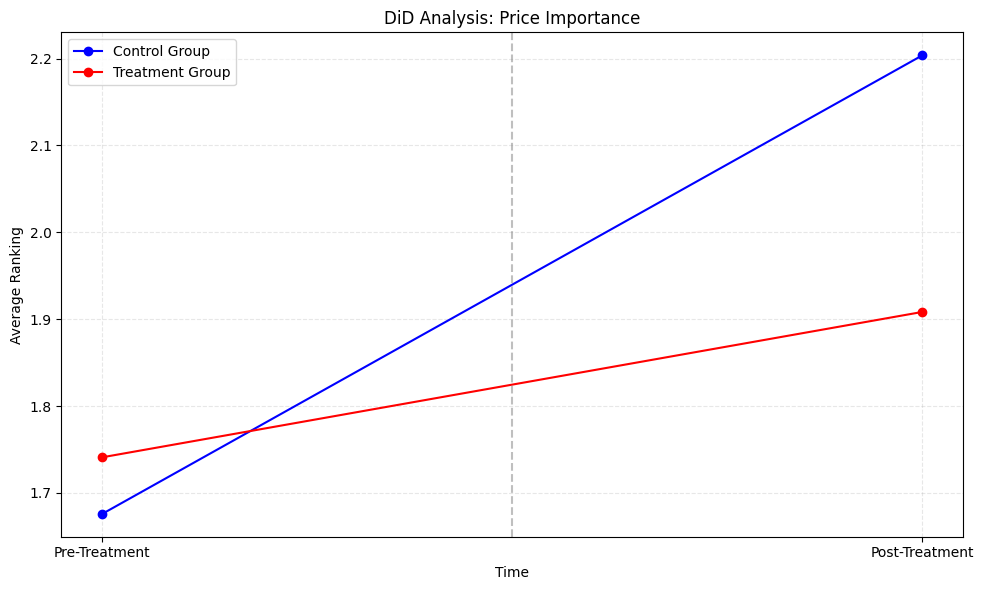

In [ ]:
# Difference-in-Differences Analysis for Airbnb Data
# Correctly interprets rankings where lower values = higher importance

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# PRICE IMPORTANCE DiD ANALYSIS

# Create pre-treatment records
pre_df = pd.DataFrame({
    'respondent_id': range(len(df4)),
    'treatment': df4['Treatment'],
    'time': 'pre',
    # Convert ranking to importance score (5 - rank) so higher values = more important
    # This makes interpretation more intuitive (positive coefficient = increased importance)
    'importance': df4['Q7_1'].astype(float)  # pre-treatment price importance
})

# Create post-treatment records
post_df = pd.DataFrame({
    'respondent_id': range(len(df4)),
    'treatment': df4['Treatment'],
    'time': 'post',
    # Convert ranking to importance score (5 - rank) so higher values = more important
    'importance':df4['Q12_1_total'].astype(float)  # post-treatment price importance
})

# Combine pre and post dataframes
price_did_df = pd.concat([pre_df, post_df], ignore_index=True)

# Create binary indicators
price_did_df['post'] = (price_did_df['time'] == 'post').astype(int)
price_did_df['did'] = price_did_df['treatment'] * price_did_df['post']

# Run DiD regression
price_model = smf.ols("conversion ~ treatment + post + treatment * post", data=price_did_df).fit()

# Print regression results
print("=== DiD ANALYSIS: PRICE IMPORTANCE ===")
print(price_model.summary().tables[1])

# Interpreting the coefficient
did_coef = price_model.params['did']
p_value = price_model.pvalues['did']

print(f"\nDiD Coefficient: {did_coef:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    direction = "INCREASED" if did_coef > 0 else "DECREASED"
    print(f"SIGNIFICANT: Treatment {direction} the ranking of price (p < 0.05)")
    # positive coefficient means increased importance
else:
    print(f"NOT SIGNIFICANT: No statistically significant effect on price importance")

# Create visualization
# Calculate means for each group and time period
means = price_did_df.groupby(['treatment', 'time'])['importance'].mean().reset_index()
pivot_means = means.pivot(index='time', columns='treatment', values='importance')

# Create plot
plt.figure(figsize=(10, 6))
plt.plot(['pre', 'post'], pivot_means[0], 'b-o', label='Control Group')
plt.plot(['pre', 'post'], pivot_means[1], 'r-o', label='Treatment Group')
plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)

plt.title('DiD Analysis: Price Importance')
plt.xlabel('Time')
plt.ylabel('Average Ranking')
plt.xticks([0, 1], ['Pre-Treatment', 'Post-Treatment'])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()

plt.show()

# Function to run DiD for any factor
def run_factor_did(df, factor_name, pre_col, post_col):
    """
    Run DiD analysis for a specific ranking factor

    Parameters:
    df (DataFrame): The original dataframe
    factor_name (str): Name of the factor for display
    pre_col (str): Column name for pre-treatment ranking
    post_col (str): Column name for post-treatment ranking
    max_rank (int): Maximum possible rank value

    Returns:
    tuple: (model result, dataframe used for analysis)
    """
    # Create pre-treatment records
    pre_df = pd.DataFrame({
        'respondent_id': range(len(df)),
        'treatment': df['Treatment'],
        'time': 'pre',
        # Convert ranking to importance score (5 - rank) so higher values = more important
        'importance': 5 - df[pre_col].astype(float)
    })

    # Create post-treatment records
    post_df = pd.DataFrame({
        'respondent_id': range(len(df)),
        'treatment': df['Treatment'],
        'time': 'post',
        'importance': df[post_col].astype(float)
    })

    # Combine pre and post dataframes
    factor_did_df = pd.concat([pre_df, post_df], ignore_index=True)

    # Create binary indicators
    factor_did_df['post'] = (factor_did_df['time'] == 'post').astype(int)
    factor_did_df['did'] = factor_did_df['treatment'] * factor_did_df['post']

    # Run DiD regression
    factor_model = smf.ols("importance ~ treatment + did", data=factor_did_df).fit()

    # Print results
    print(f"\n=== DiD ANALYSIS: {factor_name.upper()} IMPORTANCE ===")
    print("Note: Values are converted so higher numbers = higher importance")
    print(factor_model.summary().tables[1])

    # Interpreting the coefficient
    did_coef = factor_model.params['did']
    p_value = factor_model.pvalues['did']

    print(f"\nDiD Coefficient: {did_coef:.4f}")
    print(f"P-value: {p_value:.4f}")

    if p_value < 0.05:
        direction = "INCREASED" if did_coef > 0 else "DECREASED"
        print(f"SIGNIFICANT: Treatment {direction} the importance of {factor_name.lower()} (p < 0.05)")
    else:
        print(f"NOT SIGNIFICANT: No statistically significant effect on {factor_name.lower()} importance")

    return factor_model, factor_did_df

# Function to analyze all factors
def analyze_all_factors(df):
    """
    Run DiD analysis for all four ranking factors

    Parameters:
    df (DataFrame): The original dataframe
    max_rank (int): Maximum possible rank value

    Returns:
    dict: Dictionary of models and dataframes
    """
    factors = [
        ('Price', 'Q7_1', 'Q12_1_total'),
        ('Location', 'Q7_2', 'Q12_2_total'),
        ('Cover Photo', 'Q7_3', 'Q12_3_total'),
        ('Ratings', 'Q7_4', 'Q12_4_total')
    ]

    results = {}

    for factor_name, pre_col, post_col in factors:
        model, did_df = run_factor_did(df, factor_name, pre_col, post_col)
        results[factor_name] = (model, did_df)

        # Create visualization
        means = did_df.groupby(['treatment', 'time'])['importance'].mean().reset_index()
        pivot_means = means.pivot(index='time', columns='treatment', values='importance')

        plt.figure(figsize=(10, 6))
        plt.plot(['pre', 'post'], pivot_means[0], 'b-o', label='Control Group')
        plt.plot(['pre', 'post'], pivot_means[1], 'r-o', label='Treatment Group')
        plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)

        plt.title(f'DiD Analysis: {factor_name} Importance')
        plt.xlabel('Time')
        plt.ylabel('Average Ranking')
        plt.xticks([0, 1], ['Pre-Treatment', 'Post-Treatment'])
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()

    return results


=== DiD ANALYSIS: PRICE IMPORTANCE ===
Note: Values are converted so higher numbers = higher importance
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2361      0.032     70.738      0.000       2.174       2.298
treatment      0.8556      0.057     14.929      0.000       0.743       0.968
did           -1.3506      0.068    -19.978      0.000      -1.483      -1.218

DiD Coefficient: -1.3506
P-value: 0.0000
SIGNIFICANT: Treatment DECREASED the importance of price (p < 0.05)


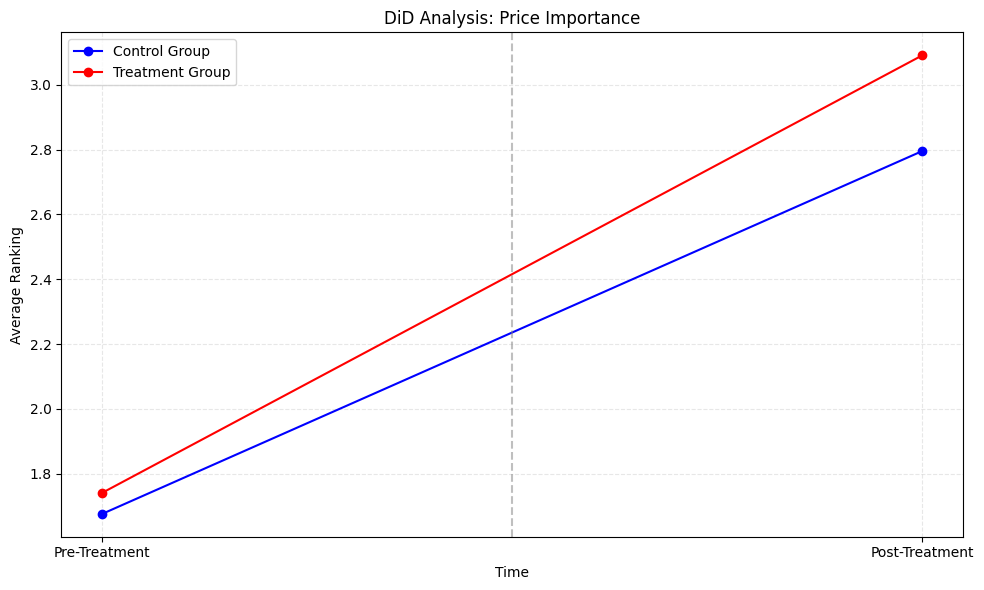


=== DiD ANALYSIS: LOCATION IMPORTANCE ===
Note: Values are converted so higher numbers = higher importance
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6333      0.028     94.192      0.000       2.578       2.688
treatment      0.4703      0.051      9.279      0.000       0.371       0.570
did           -0.5319      0.060     -8.896      0.000      -0.649      -0.415

DiD Coefficient: -0.5319
P-value: 0.0000
SIGNIFICANT: Treatment DECREASED the importance of location (p < 0.05)


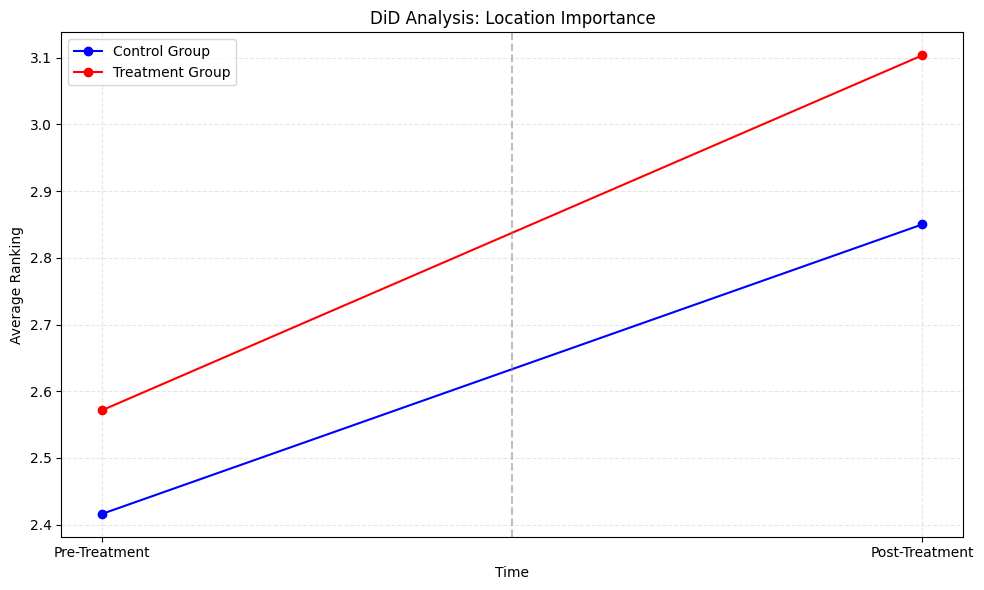


=== DiD ANALYSIS: COVER PHOTO IMPORTANCE ===
Note: Values are converted so higher numbers = higher importance
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.3162      0.035     65.943      0.000       2.247       2.385
treatment     -0.7345      0.064    -11.535      0.000      -0.859      -0.610
did            1.3327      0.075     17.741      0.000       1.185       1.480

DiD Coefficient: 1.3327
P-value: 0.0000
SIGNIFICANT: Treatment INCREASED the importance of cover photo (p < 0.05)


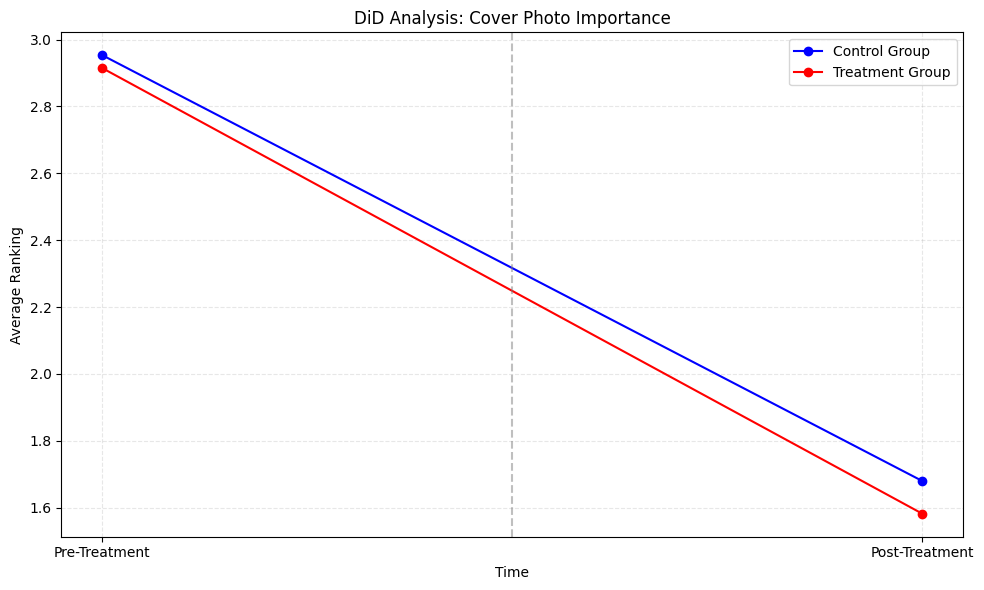


=== DiD ANALYSIS: RATINGS IMPORTANCE ===
Note: Values are converted so higher numbers = higher importance
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8145      0.027    103.208      0.000       2.761       2.868
treatment     -0.5914      0.049    -11.961      0.000      -0.688      -0.494
did            0.5498      0.058      9.427      0.000       0.435       0.664

DiD Coefficient: 0.5498
P-value: 0.0000
SIGNIFICANT: Treatment INCREASED the importance of ratings (p < 0.05)


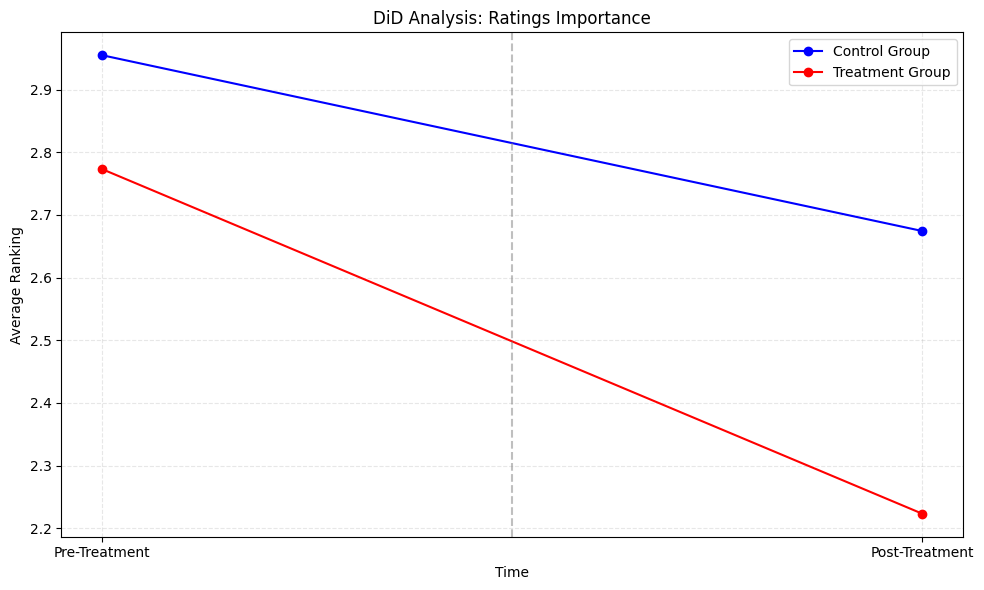

In [ ]:
all_results = analyze_all_factors(df4)

In [ ]:
# Define the columns for pre and post rankings
pre_ranking_cols = ['Q7_1', 'Q7_2', 'Q7_3', 'Q7_4']
post_ranking_cols = ['Q12_1_total', 'Q12_2_total', 'Q12_3_total', 'Q12_4_total']

# Create a function to prepare data for plotting
def prepare_ranking_data(df, pre_cols, post_cols):
    # Calculate pre and post rankings for each treatment group
    pre_rankings = df.groupby('Treatment')[pre_cols].mean()
    post_rankings = df.groupby('Treatment')[post_cols].mean()

    # Rename columns to match pre/post structure
    pre_rankings.columns = ['Price', 'Location', 'Photo', 'Rating']
    post_rankings.columns = ['Price', 'Location', 'Photo', 'Rating']

    # Melt the dataframes to create long format
    pre_melt = pre_rankings.reset_index().melt(id_vars='Treatment', var_name='Factor', value_name='Pre Ranking')
    post_melt = post_rankings.reset_index().melt(id_vars='Treatment', var_name='Factor', value_name='Post Ranking')

    # Merge pre and post rankings
    combined = pd.merge(pre_melt, post_melt, on=['Treatment', 'Factor'])

    return combined

# Prepare the data
ranking_data = prepare_ranking_data(df4, pre_ranking_cols, post_ranking_cols)

# Set up the plot
plt.figure(figsize=(12, 6))

# Create a grouped bar plot
sns.barplot(x='Factor', y='Pre Ranking', hue='Treatment',
            data=ranking_data, palette='Blues', alpha=0.7)

sns.barplot(x='Factor', y='Post Ranking', hue='Treatment',
            data=ranking_data, palette='Reds', alpha=0.7)

# Customize the plot
plt.title('Pre and Post Rankings by Treatment Group', fontsize=16)
plt.xlabel('Factors', fontsize=12)
plt.ylabel('Average Ranking', fontsize=12)
plt.legend(title='Treatment Group', labels=['Control (0)', 'Treatment (1)',
                                            'Control (0) Post', 'Treatment (1) Post'])

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout and save
plt.tight_layout()
plt.savefig('ranking_comparison.png')
plt.close()

# Print the data for reference
print(ranking_data)

   Treatment    Factor  Pre Ranking  Post Ranking
0          0     Price     2.203833      1.675958
1          1     Price     1.908367      1.741036
2          0  Location     2.149826      2.416376
3          1  Location     1.896414      2.571713
4          0     Photo     3.320557      2.952962
5          1     Photo     3.418327      2.914343
6          0    Rating     2.325784      2.954704
7          1    Rating     2.776892      2.772908


In [ ]:
# Heterogeneity test
print(smf.ols(formula= 'Q8_total ~ Treatment + Q6_total + Q3_total + Treatment:Q6_total + Treatment:Q3_total + Treatment:', data=df4).fit().summary())

                            OLS Regression Results                            
Dep. Variable:               Q8_total   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     26.17
Date:                Sun, 20 Apr 2025   Prob (F-statistic):           5.41e-25
Time:                        23:25:25   Log-Likelihood:                -2414.7
No. Observations:                1076   AIC:                             4841.
Df Residuals:                    1070   BIC:                             4871.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              7.1897      0